In [8]:
import tensorflow as tf

# Basic Neural Networks with TF

Constructing a neural network in TF low level python API allows you to create your own layers as functions to be combined in flexible ways. 


### Load the data

In [9]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

def normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std

### Normalize and split the data

In [10]:
house_dat = pd.read_csv('Housing_data/kc_house_data.csv')
house_dat.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [11]:

# load the data into numpy arrays
housing_features = house_dat[house_dat.columns.difference(['id', 'price', 'date', 'zipcode'])].values
housing_targets = house_dat.price.values
housing_targets = housing_targets / np.max(housing_targets)

n, f_dim = housing_features.shape

# normalize the features
housing_features= normalize(housing_features)

# add bias
housing_features = np.c_[np.ones((n, 1)), housing_features]

# reshape targets to TF expectation
housing_targets = np.expand_dims(housing_targets, 1)

X_train, X_test, y_train, y_test = train_test_split(housing_features,
                                                    housing_targets,
                                                    test_size=0.1)

print(X_train.shape)
print(y_train.shape)

(19451, 18)
(19451, 1)


## Set up Neural Network Hyperparameters

LR, EPOCHS, BATCHSIZE, and n_hidden are all parameters that you can play with to acheive the best performance.

In [12]:
LR = 0.01
EPOCHS = 200
BATCHSIZE = 32
n_inputs = 8
n_hidden = 32
n_output = 1

Since we will be training this network with mini-batch gradient descent we need to set up tensorflow placeholders for our input and target data. The place holders serve as buckets in our graph that we can place data into during training. We need only to define the shape of the data with respect to the feature dimensions. The `None` serves as a wildcard for the batchsize, having `None` there allows us to use any batch size that we choose during training.

In [13]:
X = tf.placeholder(tf.float32, shape=(None, f_dim+1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')

## Deep Learning Layers

When using one of the popular high level libraries for deep learning they typically frame the process as stacking a bunch of layers together. The layers are often set up in a way that allows you to chain an arbitrary number together. The workflow with TensorFlow is similar except that we will create our own layer functions rather than importing them from some library. 

Fun fact, a lot of these popular high level deep learning libraries that are built of existing frameworks started because people were building and reusing these layers functions. Some decided to release their collections of these functions as a package. A few ended up getting popular and development accelerated. 

When designing our layer functions there are a few things to consider. At the minimum, we should think about what the data going into our layer will be, how many neurons to have in each of our layers, what kind of activation function to use, and maybe how we want our weights to be initialized at the start of training. When using TensorFlow it's also a good idea to have names for all of our scopes within the graph. When we have to trouble shoot it will use that name in the traceback and if we view the graph in some of the TensorFlow visualization tools. 

In the previous notebook we set up a regression problem that we vectorized by doing a simple vector to matrix multiply. We can make that case that this is the simplest form of a neural network, in which case we should only have to perform some minor changes to create a neural network layer. What we don't want to do is a put a bunch of these single neuron functions together in parallel, this would be terribly inefficient. Instead, we want to frame our calculations as matrix operations. If we think back to that example, our weight matrix was set up with shape `[feature_dimensions, 1]` where feature_dimensions corresponds to however many columns we had in our dataset. The 1 however, we can think of as how many neurons we had in that "layer". So if we want 5 neurons in a layer we can change the shape of that matrix to `[feature_dimensions, 5]`. This will give us a vector of length 5 for every example that we've run through the network. 

```python
def dense_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        W = tf.Variable(tf.ones([n_inputs, 5]), name='hidden_weights')
        Z = tf.matmul(X, W)
        out = activation(Z)
        return out
```

Additionally, we may want to initialize our weights to something other than a matrix of ones. One popular method is to use the [He normal initialization method (https://arxiv.org/pdf/1502.01852.pdf). We can set this up quickly with two more lines and then pass the resulting `init` matrix into our `tf.Variable` weight matrix instead of starting it with `tf.ones()`.

```python
stddev = 2 / np.sqrt(n_inputs + n_units)
init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
```

### Exercise

Build your own generic dense layer function. 


In [14]:
def dense_layer(X, n_units, name, activation=None):
    '''
    Sets up a hidden layer to be used to build a multilayer perceptron. 
    
    Initializes the weights of the neurons using a normal distribution with
    standard deviation equal to 2 / sqrt(input_dimension + number_neurons)
    
    Parameters:
    X: input data for the layer
    n_units: number of neurons to use in the layer
    name: the name of the scope to be used with this layer
    activation: the tensorflow nonlinearity to be used for each neuron
    
    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        # fill in the rest below
        print('this will be a neural net layer')

### Solution

In [15]:
def dense_layer(X, n_units, name, activation=None):
    '''
    Sets up a hidden layer to be used to build a multilayer perceptron. 
    
    Initializes the weights of the neurons using a normal distribution with
    standard deviation equal to 2 / sqrt(input_dimension + number_neurons)
    
    Parameters:
    X: input data for the layer
    n_units: number of neurons to use in the layer
    name: the name of the scope to be used with this layer
    activation: the tensorflow nonlinearity to be used for each neuron
    
    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_units)
        init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
        W = tf.Variable(init, name='hidden_weights')
        b = tf.Variable(tf.zeros([n_units]), name='bias')
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

Creating a neural network from this layer definition is fairly straight forward now. We essentially just create a new named scope and stack two of our newly created layers together with the desired parameters. If we wanted more layers we would simply just add more to the center of our network definition.

We will also create TF scopes for the loss and SGD functions, a slight twist on what we did before but the functionality is the same.

In [16]:
# build the network using the hidden layer function
with tf.name_scope('dnn'):
    hidden = dense_layer(X, n_hidden, name='hidden_layer', activation=tf.nn.relu)
    y_pred = dense_layer(hidden, 1, name='output')
    
with tf.name_scope('loss'):
    error = y_pred - y
    loss = tf.reduce_mean(tf.square(error), name='mse')
    
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(LR).minimize(loss)

Train the network using mini-batch gradient descent. We will slice up our training data into batches of size `BATCHSIZE` and feed each batch into the network in succession. Just like we did with the linear model in the previous notebook, but with smaller portions of the dataset for each step rather than the whole thing. 

In [17]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()

losses = []
n_samples = X_train.shape[0]
with tf.Session() as sess:
    sess.run(init)
    
    for e in range(EPOCHS):
            
        for i in range((n_samples + BATCHSIZE - 1) // BATCHSIZE):
            sl = slice(i * BATCHSIZE, (i+1) * BATCHSIZE)
            X_b = X_train[sl]
            y_b = y_train[sl]
            _, train_loss = sess.run([train_step, loss], feed_dict={X: X_b, y: y_b})
            losses.append(train_loss)
            
        if e % 10 == 0:
            print("Epoch:", e, 
                  "Current loss:", train_loss, 
                  "Test loss:",
                  sess.run(loss, feed_dict={X: X_test, y: y_test}))
        
    save_path = saver.save(sess, '/tmp/mlp_regression.ckpt')

Epoch: 0 Current loss: 0.013532436 Test loss: 0.020779148
Epoch: 10 Current loss: 0.0012119822 Test loss: 0.0018849679
Epoch: 20 Current loss: 0.00053830986 Test loss: 0.0010365455
Epoch: 30 Current loss: 0.00036019672 Test loss: 0.0008218935
Epoch: 40 Current loss: 0.00030468177 Test loss: 0.00074304035
Epoch: 50 Current loss: 0.00028408985 Test loss: 0.00070660363
Epoch: 60 Current loss: 0.0002759433 Test loss: 0.0006861611
Epoch: 70 Current loss: 0.00027398334 Test loss: 0.00067363586
Epoch: 80 Current loss: 0.00027332548 Test loss: 0.00066422083
Epoch: 90 Current loss: 0.00027277056 Test loss: 0.0006567958
Epoch: 100 Current loss: 0.00027225673 Test loss: 0.0006507734
Epoch: 110 Current loss: 0.00027129892 Test loss: 0.0006454731
Epoch: 120 Current loss: 0.0002700194 Test loss: 0.0006406236
Epoch: 130 Current loss: 0.0002692322 Test loss: 0.00063620304
Epoch: 140 Current loss: 0.0002694088 Test loss: 0.00063229346
Epoch: 150 Current loss: 0.00026940912 Test loss: 0.0006286951
Epoch

Load the saved model and make predictions on the test set.

In [18]:
# best weight values are saved in the checkpoint
with tf.Session() as sess:
    saver.restore(sess, '/tmp/mlp_regression.ckpt')
    preds = sess.run(y_pred, feed_dict={X: X_test})
    print(sess.run(loss, feed_dict={X: X_test, y: y_test}))

INFO:tensorflow:Restoring parameters from /tmp/mlp_regression.ckpt
0.0006145615


We did better than the simple linear regression from the previous example.

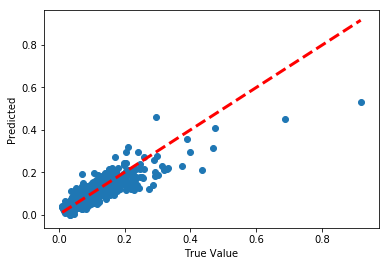

In [19]:
fig, ax = plt.subplots()
ax.scatter(y_test, preds)
ax.plot([y_test.min(), y_test.max()], 
        [y_test.min(), y_test.max()], '--', lw=3, color='r')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted')
plt.show()